In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os

if not os.path.exists('thinkdsp.py'):
    !python -m wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

from thinkdsp import decorate, read_wave, Spectrum, Wave

# Упражнение 5.1

Блокнот Jupyter этой главы, chap05.ipynb, содержит приложение, в котором можно вычислить автокорреляции для различных lag. Оцените высоты тона вокального чирпа для нескольких времен начала сегмента.

In [5]:
if not os.path.exists('28042__bcjordan__voicedownbew.wav'):
    !python -m wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/28042__bcjordan__voicedownbew.wav


Saved under 28042__bcjordan__voicedownbew.wav


In [6]:
from thinkdsp import read_wave

wave = read_wave('28042__bcjordan__voicedownbew.wav')
wave.normalize()
wave.make_audio()

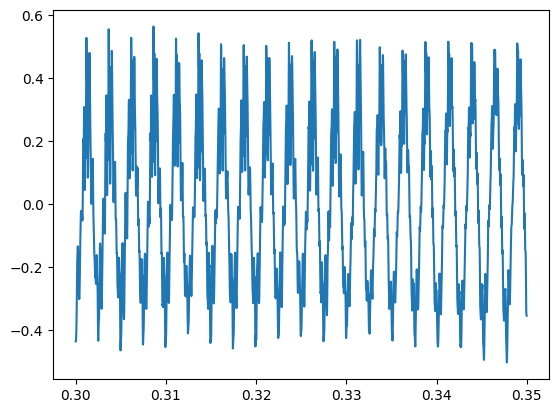

In [7]:
segment = wave.segment(start=0.3, duration=0.05)
segment.plot()

Функция автокорелляции

In [10]:
def serial_corr (wave, lag=1):
    N = len (wave)
    y1 = wave.ys[lag:]
    y2 = wave.ys[:N-lag]
    corr = np.corrcoef(y1, y2)[0, 1]
    return corr

In [8]:
def autocorr (wave):
    lags = range(len(wave.ys)//2)
    corrs = [serial_corr(wave, lag) for lag in lags]
    return lags, corrs

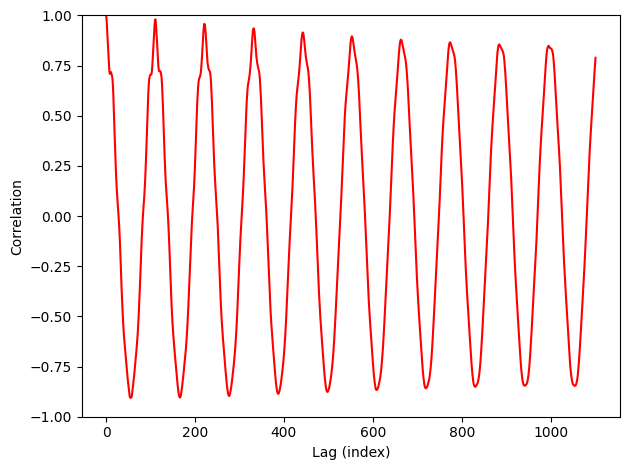

In [11]:
lags, corrs = autocorr(segment)
plt.plot(lags, corrs, color='red')
decorate(xlabel='Lag (index)', ylabel='Correlation', ylim=[-1, 1])

In [12]:
low, high = 50, 200
lag = np.array(corrs[low:high]).argmax() + low
print("lag = ",lag)

lag =  111


In [13]:
period = lag / segment.framerate
frequency = 1 / period
print("freq = ", frequency)

freq =  397.2972972972973


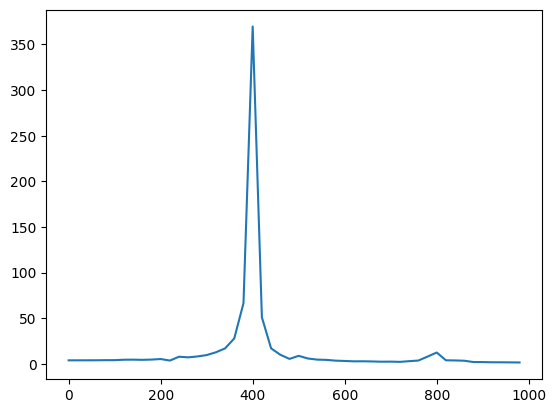

In [14]:

spectrum = segment.make_spectrum().plot(high = 1000)

Высота тона полностью совпадает со спектром.

Вычислим максимальную частоту на другом промежутке:

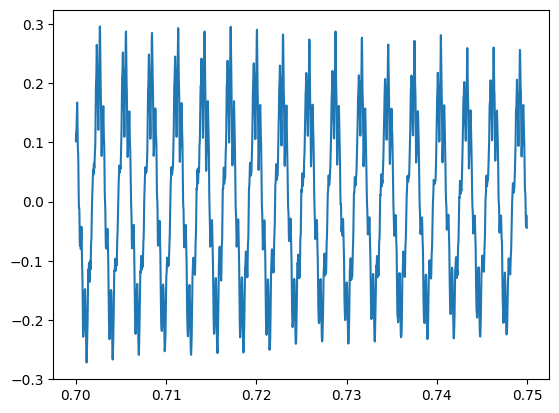

In [15]:
segment = wave.segment(start=0.7, duration=0.05)
segment.plot()

Автокорелляция:

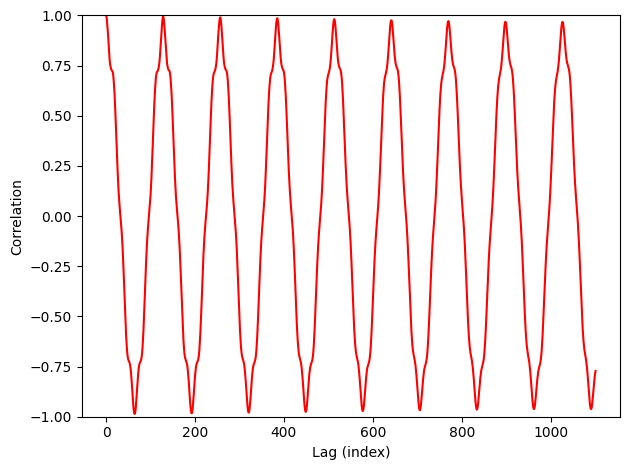

In [16]:
lags, corrs = autocorr(segment)
plt.plot(lags, corrs, color='red')
decorate(xlabel='Lag (index)', ylabel='Correlation', ylim=[-1, 1])

In [17]:
low, high = 50, 200
lag = np.array(corrs[low:high]).argmax() + low
print("lag = ",lag)

lag =  128


In [18]:
period = lag / segment.framerate
frequency = 1 / period
print("freq = ", frequency)

freq =  344.53125


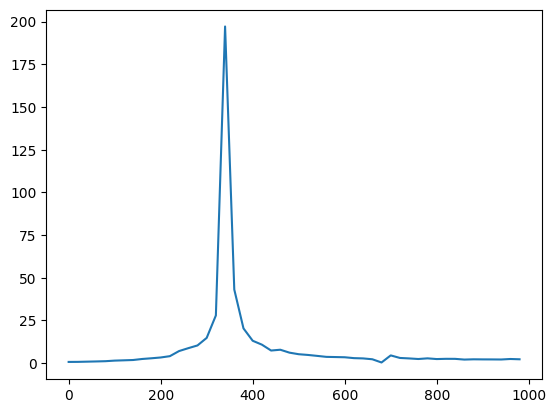

In [19]:
spectrum = segment.make_spectrum().plot(high = 1000)



# Упражнение 5.2


Пример кода в chap05.ipynb показывает, как использовать автокорреляцию для оценки основной частоты периодического сигнала. Инкапсулируйте этот код в функцию, названную estimate_fundamental, и используйте ее для отслеживания высоты тона записанного звука.

Проверьте, насколько хорошо она работает, накладывая оценки высоты тона на спектрограмму записи.

Воспользуемся тем же примером из упражнения 1. Вот спектрограмма:

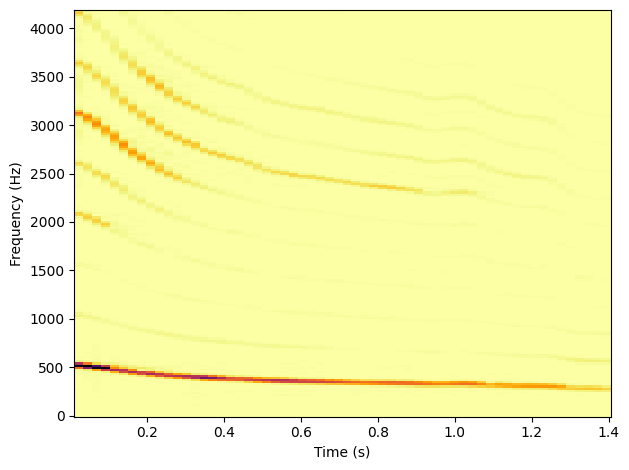

In [21]:
wave.make_spectrogram(2048).plot(high=4200)
decorate(xlabel='Time (s)', 
         ylabel='Frequency (Hz)')

А вот функция, которая инкапсулирует код из главы 5.

In [23]:
def estimate_fundamental(segment, low=70, high=150):
    lags, corrs = autocorr(segment)
    lag = np.array(corrs[low:high]).argmax() + low
    period = lag / segment.framerate
    frequency = 1 / period
    return frequency

Вот пример того, как это работает.

In [24]:
duration = 0.01
segment = wave.segment(start=0.2, duration=duration)
freq = estimate_fundamental(segment)
freq

436.63366336633663

А вот петля, которая отслеживает высоту звука по сэмплу.

ts является серединой каждого сегмента.

In [25]:
step = 0.05
starts = np.arange(0.0, 1.4, step)

ts = []
freqs = []

for start in starts:
    ts.append(start + step/2)
    segment = wave.segment(start=start, duration=duration)
    freq = estimate_fundamental(segment)
    freqs.append(freq)


Вот кривая отслеживания высоты тона, наложенная на спектрограмму:

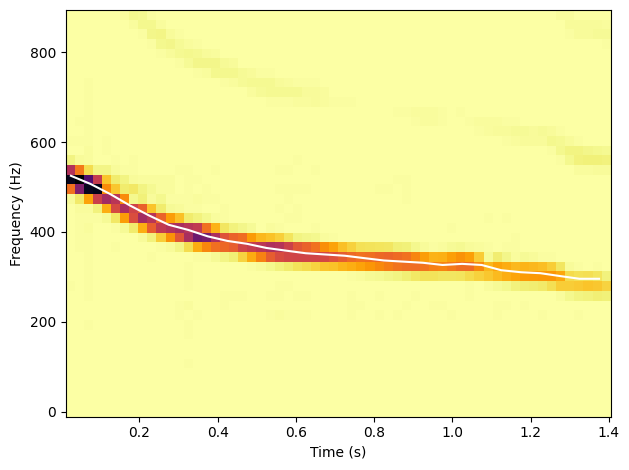

In [26]:
wave.make_spectrogram(2048).plot(high=900)
plt.plot(ts, freqs, color='white')
decorate(xlabel='Time (s)', 
                     ylabel='Frequency (Hz)')

# Упражнение 5.3



Для упражнений в предыдущей главе были нужны исторические цены BitCoins, и надо было оценить спектр мощности изменения цен. Используя те же данные, вычислите автокорреляции цен в платежной системе Bitcoin. Быстро ли спадает автокорреляционная функция? Есть ли признаки периодичности процесса?

Для начала импортируем необходимые библиотеки:

Используя данные из предыдущей главы, вычислим автокорреляцию цен на биткойны. Определим, имеются ли признаки периодического поведения.

Получим данные:

In [31]:
if not os.path.exists('BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv'):
    !python -m wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv


Saved under BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv


Создадим pandas dataframe на основе данных:

In [32]:
import pandas as pd

df = pd.read_csv('BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv', 
                 parse_dates=[0])

ys = df['Closing Price (USD)']
ts = df.index

Распечатаем график цены биткоина:

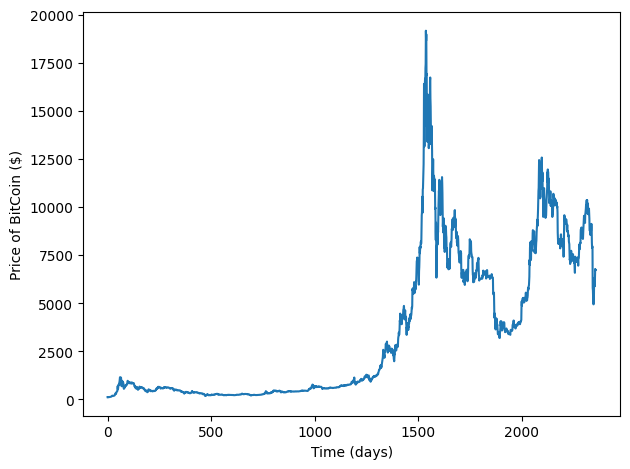

In [33]:
from thinkdsp import Wave

wave = Wave(ys, ts, framerate=1)
wave.plot()
decorate(xlabel='Time (days)',
         ylabel='Price of BitCoin ($)')

Вот функция автокорреляции, использующая статистическое определение, которое устраняет смещения, нормализует и стандартизирует; то есть он сдвигает среднее значение к нулю, делит на стандартное отклонение и делит сумму на N.

In [34]:
def autocorr(wave):
    """Computes and plots the autocorrelation function.

    wave: Wave
    """
    lags = np.arange(len(wave.ys)//2)
    corrs = [serial_corr(wave, lag) for lag in lags]
    return lags, corrs

In [35]:
def serial_corr(wave, lag=1):
    """Computes serial correlation with given lag.

    wave: Wave
    lag: integer, how much to shift the wave

    returns: float correlation coefficient
    """
    n = len(wave)
    y1 = wave.ys[lag:]
    y2 = wave.ys[:n-lag]
    corr_mat = np.corrcoef(y1, y2)
    return corr_mat[0, 1]

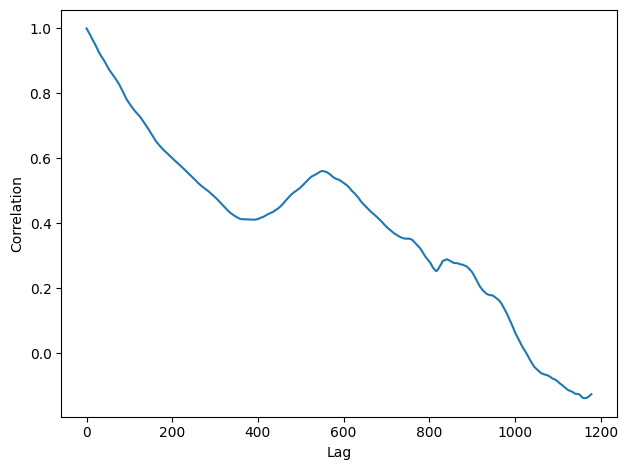

In [36]:
lags, corrs = autocorr(wave)
plt.plot(lags, corrs)
decorate(xlabel='Lag',
         ylabel='Correlation')

ACF медленно падает по мере увеличения запаздывания, что указывает на некий шум.

Мы можем сравнить реализацию autocorr с np.correlate, которая использует определение корреляции, используемое при обработке сигналов. Он не устраняет смещение, не нормализует и не стандартизирует волну.

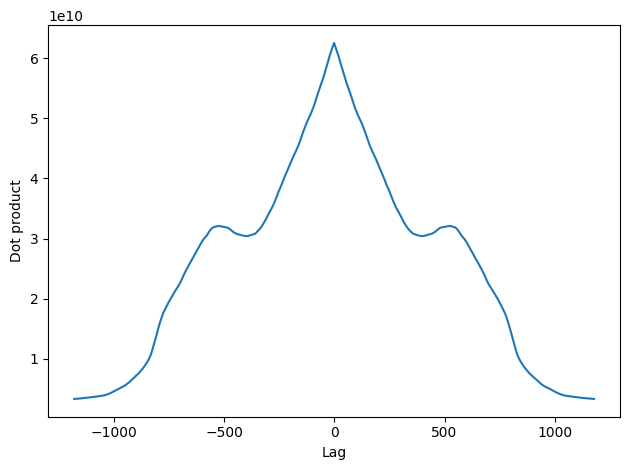

In [38]:
N = len(wave)
corrs2 = np.correlate(wave.ys, wave.ys, mode='same')
lags = np.arange(-N//2, N//2)
plt.plot(lags, corrs2)
decorate(xlabel='Lag',
         ylabel='Dot product')

Вторая половина результата соответствует положительным лагам:

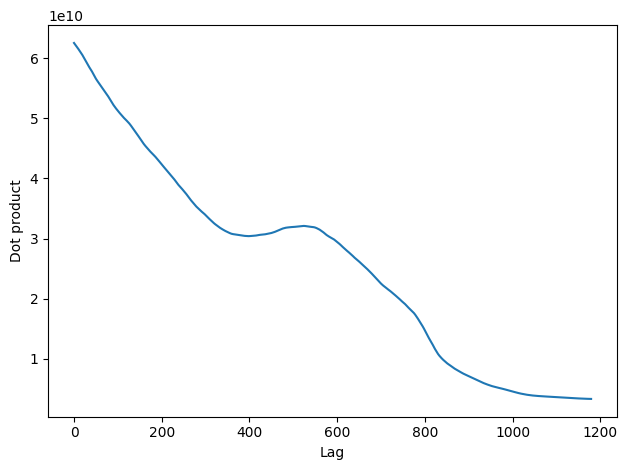

In [39]:
N = len(corrs2)
half = corrs2[N//2:]
plt.plot(half)
decorate(xlabel='Lag',
         ylabel='Dot product')

Мы можем стандартизировать результаты постфактум, разделив их на длины:

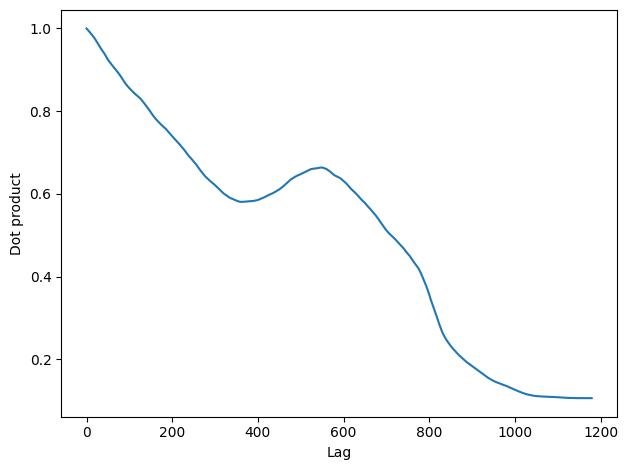

In [40]:
lengths = range(N, N//2, -1)
half /= lengths
half /= half[0]
plt.plot(half)
decorate(xlabel='Lag',
         ylabel='Dot product')

Теперь мы можем сравнить их.

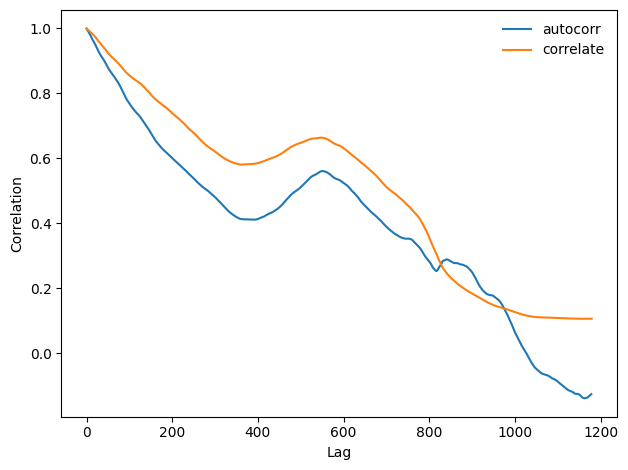

In [41]:
plt.plot(corrs, label='autocorr')
plt.plot(half, label='correlate')
decorate(xlabel='Lag', ylabel='Correlation')

Даже после стандартизации результаты выглядят существенно иначе.

Для этого набора данных более подходящим является статистическое определение АКФ.

# Упражнение 5.4

В репозитории этой книги есть блокнот Jupyter под названием saxophone.ipynb, в котором исследуются автокорреляция, восприятие высоты тона и явление, называемое подавленная основная. Прочтите этот блокнот и «погоняйте» примеры. Выберите другой сегмент записи и вновь поработайте с примерами.

У Ви Харт (Vi Hart) есть отличное видео под названием «Так что же там с шумами(Наука и математика звука, частота и высота тона)». Она демонстрирует феномен подавленной основной и объясняет, как воспринимается высота тона (по крайней мере, насколько об этом известно). См. https://www.youtube.com/watch?v=i_0DXxNeaQ0.

In [42]:
if not os.path.exists('100475__iluppai__saxophone-weep.wav'):
    !python -m wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/100475__iluppai__saxophone-weep.wav


Saved under 100475__iluppai__saxophone-weep.wav


In [43]:
wave = read_wave('100475__iluppai__saxophone-weep.wav')
wave.normalize()
wave.make_audio()

Возьмем отрезок

In [44]:
segment = wave.segment(start=5, duration=0.2)
segment.make_audio()

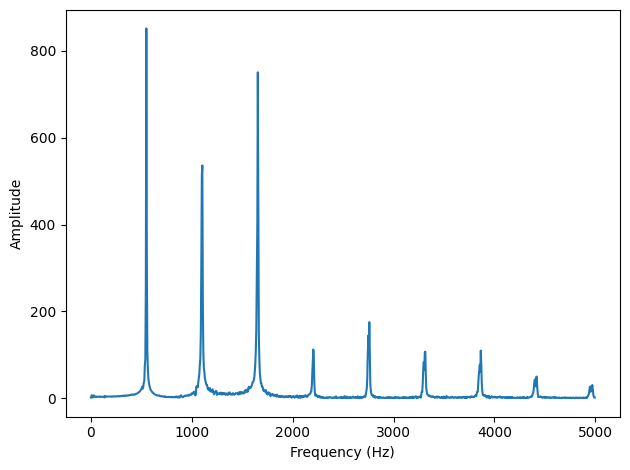

In [46]:
spectrum = segment.make_spectrum()
spectrum.plot(high=5000)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

In [47]:
spectrum.peaks()[:6]

[(851.286051294676, 550.0),
 (750.4194893967243, 1655.0),
 (535.8765203756585, 1105.0),
 (512.9125469185768, 1100.0),
 (432.157194360438, 1660.0),
 (401.13651257944906, 1650.0)]


Возьмем треугольный сигнал с такой же основной частотой

In [48]:
from thinkdsp import TriangleSignal

TriangleSignal(freq=550).make_wave(duration=0.2).make_audio()

Сейчас у сигналов одинаковая воспринимаемая частота - 550

Для анализа применим нашу автокорреляционную функцию

In [50]:
def autocorr_(segment):
    corrs = np.correlate(segment.ys, segment.ys, mode='same')
    N = len(corrs)
    lengths = range(N, N//2, -1)

    half = corrs[N//2:].copy()
    half /= lengths
    half /= half[0]
    return half

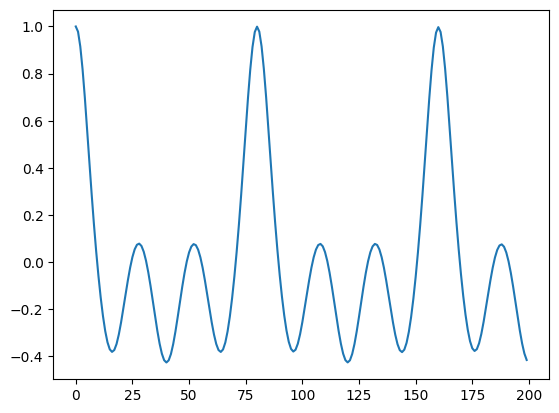

In [51]:
corrs = autocorr_(segment)
plt.plot(corrs[:200])

In [52]:

corrs[79], corrs[80], corrs[81]

(0.9764409474654036, 0.9992407118598035, 0.978030668352388)


Пик при lag = 80

In [53]:

print("Fmax = ", estimate_fundamental(segment))

Fmax =  551.25


Уберем основной тон:

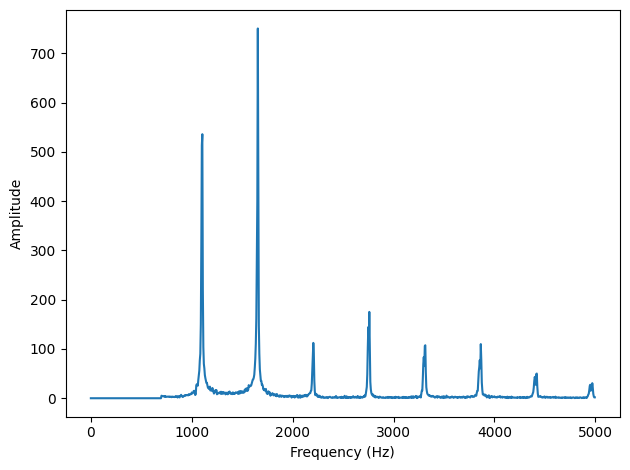

In [54]:
spectrum2 = segment.make_spectrum()
spectrum2.high_pass(700)
spectrum2.plot(high=5000)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

In [55]:
segment2 = spectrum2.make_wave()
segment2.make_audio()

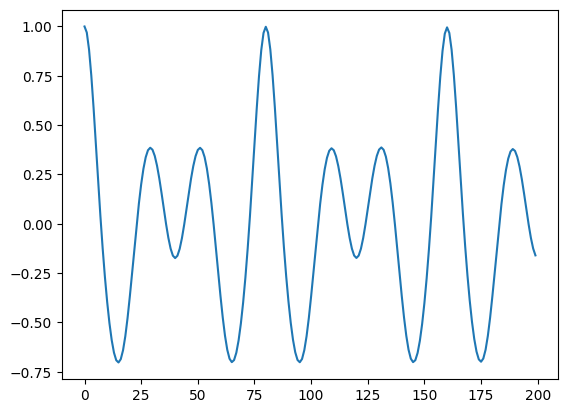

In [56]:
corrs = autocorr_(segment2)
plt.plot(corrs[:200])

In [57]:
corrs[79], corrs[80], corrs[81]

(0.96715203971728, 0.9984968648709538, 0.9691066543157081)

Мы продолжаем воспринимать один и тот же звук, даже если основная частота изменена, потому что гармоники этой частоты всё ещё присутствуют и влияют на наше восприятие.